# Introductory tutorial

In [1]:
from tespy.components import MovingBoundaryHeatExchanger, CycleCloser, Pump, Motor, PowerBus, Turbine, Source, Sink, Generator, PowerSink
from tespy.networks import Network
from tespy.connections import PowerConnection, Connection


nw = Network()
nw.units.set_defaults(
    temperature="°C",
    pressure="bar",
    heat="kW",
    power="kW"
)

In [2]:
turbine = Turbine("turbine")
recuperator = MovingBoundaryHeatExchanger("recuperator")
condenser = MovingBoundaryHeatExchanger("condenser")
pump = Pump("pump")
preheater = MovingBoundaryHeatExchanger("preheater")
evaporator = MovingBoundaryHeatExchanger("evaporator")
cc = CycleCloser("cc")

geo_source = Source("geo production")
geo_sink = Sink("geo injection")

air_source = Source("air source")
air_sink = Sink("air sink")

In [3]:
a1 = Connection(geo_source, "out1", evaporator, "in1", label="a1")
a2 = Connection(evaporator, "out1", preheater, "in1", label="a2")
a3 = Connection(preheater, "out1", geo_sink, "in1", label="a3")

b1 = Connection(cc, "out1", turbine, "in1", label="b1")
b2 = Connection(turbine, "out1", recuperator, "in1", label="b2")
b3 = Connection(recuperator, "out1", condenser, "in1", label="b3")
b4 = Connection(condenser, "out1", pump, "in1", label="b4")
b5 = Connection(pump, "out1", recuperator, "in2", label="b5")
b6 = Connection(recuperator, "out2", preheater, "in2", label="b6")
b7 = Connection(preheater, "out2", evaporator, "in2", label="b7")
b8 = Connection(evaporator, "out2", cc, "in1", label="b8")

c1 = Connection(air_source, "out1", condenser, "in2", label="c1")
c2 = Connection(condenser, "out2", air_sink, "in1", label="c2")

nw.add_conns(a1, a2, a3, b1, b2, b3, b4, b5, b6, b7, b8, c1, c2)

generator = Generator("generator")
motor = Motor("motor")
power_bus = PowerBus("bus", num_in=1, num_out=2)
grid = PowerSink("grid")

e1 = PowerConnection(turbine, "power", generator, "power_in", label="e1")
e2 = PowerConnection(generator, "power_out", power_bus, "power_in1", label="e2")
e3 = PowerConnection(power_bus, "power_out1", motor, "power_in", label="e3")
e4 = PowerConnection(motor, "power_out", pump, "power", label="e4")
e5 = PowerConnection(power_bus, "power_out2", grid, "power", label="e5")

nw.add_conns(e1, e2, e3, e4, e5)

generator.set_attr(eta=0.98)
motor.set_attr(eta=0.98)

In [4]:
a1.set_attr(fluid={"water": 1}, T=200, p=35, m=10)
a2.set_attr(T=155)

b1.set_attr(fluid={"Isopentane": 1}, x=1, T=150)

b3.set_attr(td_dew=5, T_dew=30)
b4.set_attr(td_bubble=5)
b7.set_attr(x=0)

c1.set_attr(fluid={"air": 1}, T=10, p=1)
c2.set_attr(T=20)

recuperator.set_attr(dp1=0, dp2=0)
condenser.set_attr(dp1=0, dp2=0)
preheater.set_attr(dp1=0, dp2=0)
evaporator.set_attr(dp1=0, dp2=0)

turbine.set_attr(eta_s=0.8)
pump.set_attr(eta_s=0.7)

In [5]:
nw.solve("design")

b3.set_attr(T_dew=None)
condenser.set_attr(td_pinch=5)

a2.set_attr(T=None)
evaporator.set_attr(td_pinch=5)

nw.solve("design")

nw.print_results()


 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 1.97e+06   | 0 %        | 3.59e+02   | 0.00e+00   | 6.42e+05   | 0.00e+00   | 2.20e+06   
 2     | 5.69e+06   | 0 %        | 3.86e-09   | 0.00e+00   | 4.52e+05   | 0.00e+00   | 1.25e+06   
 3     | 5.11e-01   | 69 %       | 4.63e-14   | 0.00e+00   | 2.29e-02   | 0.00e+00   | 3.85e-01   
 4     | 1.84e-07   | 100 %      | 4.63e-14   | 0.00e+00   | 4.77e-10   | 0.00e+00   | 1.80e-07   
 5     | 6.38e-10   | 100 %      | 0.00e+00   | 0.00e+00   | 3.71e-11   | 0.00e+00   | 2.52e-10   
Total iterations: 5, Calculation time: 0.02 s, Iterations per second: 249.97

 iter  | residual   | progress   | massflow   | pressure   | enthalpy   | fluid      | component  
-------+------------+------------+------------+------------+------------+------------+------------
 1     | 5.24e+00   | 58 %    

In [6]:
from fluprodia import FluidPropertyDiagram
from matplotlib import pyplot as plt


diagram = FluidPropertyDiagram("Isopentane")

diagram.set_unit_system(T="°C", p="bar")
diagram.set_isolines_subcritical(0, 200)
diagram.calc_isolines()

In [7]:
from tespy.tools import get_plotting_data


processes, points = get_plotting_data(nw, "b1")
processes = {
    key: diagram.calc_individual_isoline(**value)
    for key, value in processes.items()
    if value is not None
}

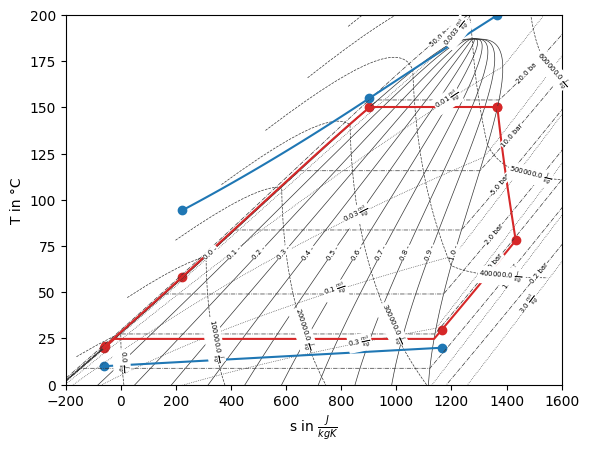

In [8]:
fig, ax = plt.subplots(1)

diagram.draw_isolines(fig, ax, "Ts", -200, 1600, 0, 200)

for label, values in processes.items():
    _ = ax.plot(values["s"], values["T"], label=label, color="tab:red")

for label, point in points.items():
    _ = ax.scatter(point["s"], point["T"], label=label, color="tab:red")


from tespy.tools.plotting import get_heatexchanger_secondary_Ts


other_processes, other_points = get_heatexchanger_secondary_Ts(nw, "b1")
for data in other_processes.values():
    for label, values in data.items():
        _ = ax.plot(values["s"], values["T"], label=label, color="tab:blue")

for data in other_points.values():
    for label, point in data.items():
        _ = ax.scatter(point["s"], point["T"], label=label, color="tab:blue")

### exergy analysis

In [9]:
from exerpy import ExergyAnalysis

In [10]:
ean = ExergyAnalysis.from_tespy(nw, 10 + 273.15, 1e5)  # does not yet sync with tespy units


ean.analyse(
    E_F={"outputs": ["a3"], "inputs": ["a1"]},
    E_P={"outputs": [], "inputs": ["e5"]},  # this is an input to the product
    E_L={"outputs": ["c1"], "inputs": ["c2"]}  # c2 is an input to the fuel
)

ean.exergy_results()  # currently no Sankey :(

Component class Sink not available in exerpy.
Component class Source not available in exerpy.
Component class PowerBus not available in exerpy.
Component class PowerSink not available in exerpy.



Material Connection Exergy Analysis Results:
+----+--------------+------------+----------+-----------+-------------+-------------+----------+----------------+---------------+---------------+----------------+
|    | Connection   |   m [kg/s] |   T [°C] |   p [bar] |   h [kJ/kg] |   s [J/kgK] |   E [kW] |   e^PH [kJ/kg] |   e^T [kJ/kg] |   e^M [kJ/kg] | e^CH [kJ/kg]   |
|----+--------------+------------+----------+-----------+-------------+-------------+----------+----------------+---------------+---------------+----------------|
|  0 | a1           |     10.000 |  200.000 |    35.000 |     853.060 |    2327.451 | 1947.025 |        194.702 |       191.304 |         3.398 |                |
|  1 | a2           |     10.000 |  155.000 |    35.000 |     655.570 |    1888.996 | 1213.609 |        121.361 |       117.963 |         3.398 |                |
|  2 | a3           |     10.000 |   94.332 |    35.000 |     397.888 |    1240.201 |  473.845 |         47.384 |        43.986 |         3

(       Component     E_F [kW]    E_P [kW]    E_D [kW]   E_L [kW]      ε [%]  \
 0      condenser   181.702369   63.333117  118.369252   0.000000  34.855416   
 1     evaporator   733.415282  653.399835   80.015448   0.000000  89.090022   
 4      generator   922.182331  903.738684   18.443647   0.000000  98.000000   
 5          motor    41.883152   41.045489    0.837663   0.000000  98.000000   
 2      preheater   739.764650  645.210490   94.554160   0.000000  87.218346   
 6           pump    41.045489   29.177823   11.867666   0.000000  71.086552   
 3    recuperator   117.849742   83.099614   34.750128   0.000000  70.513191   
 7        turbine  1111.335650  922.182331  189.153319   0.000000  82.979641   
 TOT          TOT  1473.179932  861.855532  547.991283  63.333117  58.503073   
 
          y [%]      y* [%]  
 0     8.034949   21.600572  
 1     5.431478   14.601591  
 4     1.251962    3.365682  
 5     0.056861    0.152861  
 2     6.418371   17.254683  
 6     0.805582   